# 🌟 Instacart Customer Profiling and Reporting Analysis

## Table of Contents

1. Importing Libraries and Data
2. Data Security: PII Removal
3. Regional Segmentation
4. Regional Spending Analysis
5. Excluding Low-Activity Customers
6. Customer Profiling
7. Aggregation and Comparison
8. Visualization and Export

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import os

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

This is the standard first step for any project. You are bringing in the necessary tools (libraries like pandas and matplotlib) and the raw material (your large merged data set) so Python can actually work with them.

In [2]:
# Define the path to main project folder
path = r'C:\Users\howel\OneDrive\Instacart Basket Analysis'

# Import the most recent merged data set
df_merged = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_cust_merged.pkl'))

In [3]:
# Drop columns that contain PII (e.g., names)
# The 'State' column is needed for regional analysis
df_merged = df_merged.drop(columns = ['first_name', 'last_name'])

# Check columns to confirm they are gone
print(df_merged.columns)

Index(['Unnamed: 0', 'order_id', 'user_id', 'order_number',
       'orders_day_of_week', 'order_hour_of_day', 'days_since_prior_order',
       'new_customer', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'prices', '_merge',
       'max_order', 'loyalty_flag', 'average_price', 'spending_flag',
       'median_days', 'order_frequency_flag', 'gender', 'state', 'age',
       'date_joined', 'n_dependants', 'fam_status', 'income'],
      dtype='object')


This step addresses data ethics. You are checking for and removing PII, such as customer names or specific addresses. This is critical because this data could be traced back to an individual, and you must protect customer information, especially before sharing any results.

In [4]:
# Define lists of states for each region
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
south = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

# Create a new 'Region' column using the loc() function
df_merged.loc[df_merged['state'].isin(northeast), 'Region'] = 'Northeast'
df_merged.loc[df_merged['state'].isin(midwest), 'Region'] = 'Midwest'
df_merged.loc[df_merged['state'].isin(south), 'Region'] = 'South'
df_merged.loc[df_merged['state'].isin(west), 'Region'] = 'West'

# Check the frequency of the new column to make sure it worked
print(df_merged['Region'].value_counts(dropna=False))

Region
South        10791885
West          8292913
Midwest       7597325
Northeast     5722736
Name: count, dtype: int64


The Instacart team wants to know if ordering habits differ based on where a customer lives. You are using the 'State' column to group all 50 states into the four general U.S. regions (Northeast, South, Midwest, West). This creates a new, high-level 'Region' column that makes geographical comparison possible.

In [5]:
# Create a crosstab between 'Region' and your spending flag (e.g., 'Spending_Flag')
spending_by_region = pd.crosstab(df_merged['Region'], df_merged['spending_flag'], dropna=False)

# View the results
print(spending_by_region)

spending_flag  High spender  Low spender
Region                                  
Midwest              155975      7441350
Northeast            108225      5614511
South                209691     10582194
West                 160354      8132559


After creating the 'Region' column, you run a crosstab (like a Python pivot table) to compare your new 'Region' column against the existing 'Spending_Flag' (High/Low Spender). The goal is to see if any region has a noticeably higher percentage of high-spending customers, which would tell Instacart where their most valuable customer base is located.

In [6]:
# Create the flag: 'low_activity' if max order < 5, 'regular_activity' otherwise
df_merged.loc[df_merged['max_order'] < 5, 'Activity_Flag'] = 'Low-Activity'
df_merged.loc[df_merged['max_order'] >= 5, 'Activity_Flag'] = 'Regular-Activity'

# Check the counts
print(df_merged['Activity_Flag'].value_counts(dropna=False))

Activity_Flag
Regular-Activity    30964564
Low-Activity         1440295
Name: count, dtype: int64


In [7]:
# Create a sub-sample of only the low-activity customers
df_low_activity = df_merged[df_merged['Activity_Flag'] == 'Low-Activity']

# Export this sample to Prepared Data folder as a pickle file
df_low_activity.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'low_activity_customers.pkl'))

The CFO asked to exclude customers who don't generate much revenue. You are filtering your data to keep only those customers who have placed 5 or more orders. By saving the excluded group and creating a smaller, filtered DataFrame (df_active), you ensure all your subsequent profiling and analysis focuses only on the profitable, active users.

In [8]:
# Filter the main DataFrame to exclude 'Low-Activity' customers
# Use .copy() to ensure df_active is a true, independent copy
df_active = df_merged[df_merged['Activity_Flag'] == 'Regular-Activity'].copy()

# Check the shape of the new DataFrame to confirm the exclusion worked
print(df_active.shape)

(30964564, 31)


In [9]:
# 1. Profile based on Age and Dependents
# Elderly/Retired: Age > 60 AND No dependents (n_dependants == 0)
df_active.loc[(df_active['age'] > 60) & (df_active['n_dependants'] == 0), 'Customer_Profile'] = 'Elderly Singles'

# Young Parents: Age < 40 AND Has dependants (n_dependants >= 1)
df_active.loc[(df_active['age'] < 40) & (df_active['n_dependants'] >= 1), 'Customer_Profile'] = 'Young Parents'

# Middle Aged High Spenders: Age 40-60 AND High income (income > 100000)
df_active.loc[(df_active['age'] >= 40) & (df_active['age'] <= 60) & (df_active['income'] > 100000), 'Customer_Profile'] = 'Mid-Age Affluent'

# Create a catch-all for the rest by assigning the result of fillna back to the column
df_active['Customer_Profile'] = df_active['Customer_Profile'].fillna('General Adult')

This is the core segmentation step. You are combining several demographic variables (Age, Income, Dependents) to sort customers into meaningful groups, like 'Young Parents' or 'Mid-Age Affluent.' These profiles are used to create highly relevant advertising, promotions, and recommendations for different customers.

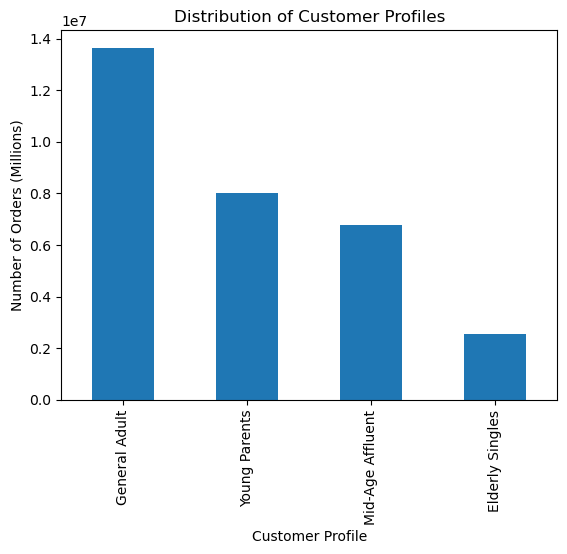

In [10]:
# Create a bar chart to visualize the profile distribution
profile_bar = df_active['Customer_Profile'].value_counts().plot.bar(
    title='Distribution of Customer Profiles',
    xlabel='Customer Profile',
    ylabel='Number of Orders (Millions)'
)

# Export the chart
profile_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_distribution_bar.png'))

In [11]:
# Aggregate spending (e.g., 'prices') and frequency (e.g., 'days_since_prior_order')
profile_agg = df_active.groupby('Customer_Profile').agg({
    'days_since_prior_order': ['mean', 'min', 'max'],
    'prices': ['mean', 'min', 'max']
})

# View the results
print(profile_agg)

                 days_since_prior_order                prices              
                                   mean  min   max       mean  min      max
Customer_Profile                                                           
Elderly Singles               10.741025  0.0  30.0  11.633160  1.0  99999.0
General Adult                 10.839122  0.0  30.0  10.918393  1.0  99999.0
Mid-Age Affluent              10.810487  0.0  30.0  13.887725  1.0  99999.0
Young Parents                 10.782982  0.0  30.0  12.102786  1.0  99999.0


Once you have your customer profiles, you use the groupby() function to calculate average spending (mean of 'prices') and average frequency (mean of 'days_since_prior_order') for each group. This shows you how each profile behaves (e.g., 'Young Parents' order frequently but spend less per order) and where they are located (Profile vs. Region) or what they buy (Profile vs. Department).

In [12]:
# Crosstab: Profile vs. Region
profile_region_ct = pd.crosstab(df_active['Customer_Profile'], df_active['Region'], dropna=False)

# Crosstab: Profile vs. Most Popular Department
# Filter to only the top 5 departments for simplicity
profile_dept_ct = pd.crosstab(df_active['Customer_Profile'], df_active['department_id'], dropna=False)

# View and analyze the results
print(profile_region_ct)

Region            Midwest  Northeast    South     West
Customer_Profile                                      
Elderly Singles    594878     460190   838254   639779
General Adult     3148665    2405486  4570112  3519349
Mid-Age Affluent  1650732    1197433  2200128  1735023
Young Parents     1867238    1401576  2702645  2033076


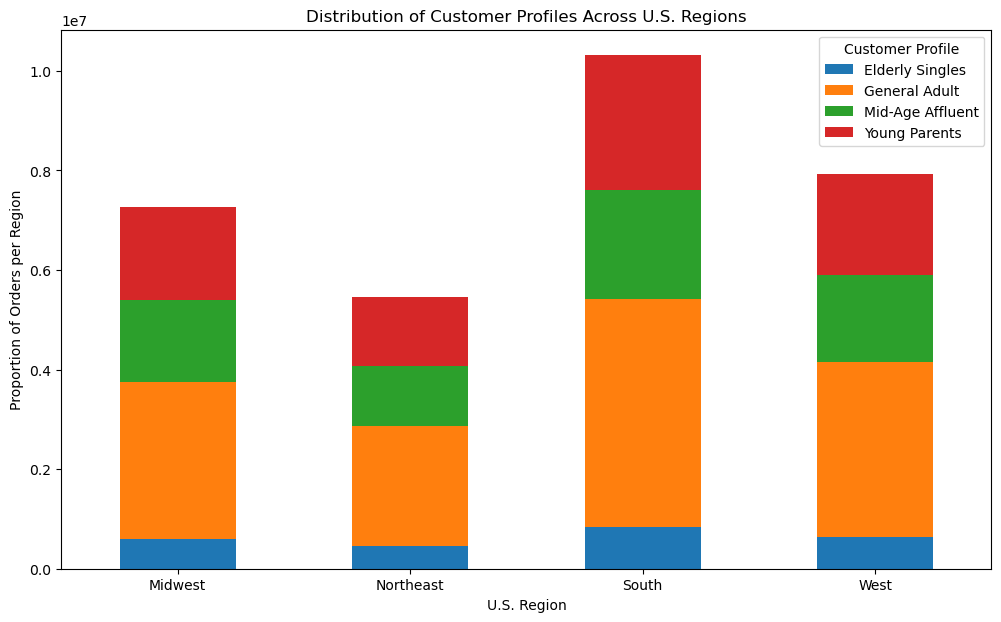

In [13]:
# 1. Prepare data for the plot
# Use pd.crosstab to get the counts for plotting
region_profile_counts = pd.crosstab(df_active['Region'], df_active['Customer_Profile'])

# 2. Create the stacked bar chart
# The 'normalize='index'' command is great because it shows the distribution (percentage) 
# of profiles *within* each region, which is often easier to interpret.
region_profile_bar = region_profile_counts.plot(
    kind='bar', 
    stacked=True,
    figsize=(12, 7),
    rot=0,
    title='Distribution of Customer Profiles Across U.S. Regions'
)

# Set labels for clarity
region_profile_bar.set_ylabel('Proportion of Orders per Region')
region_profile_bar.set_xlabel('U.S. Region')
region_profile_bar.legend(title='Customer Profile')

# 3. Export the chart to your Visualizations folder
region_profile_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_vs_region_bar.png'))

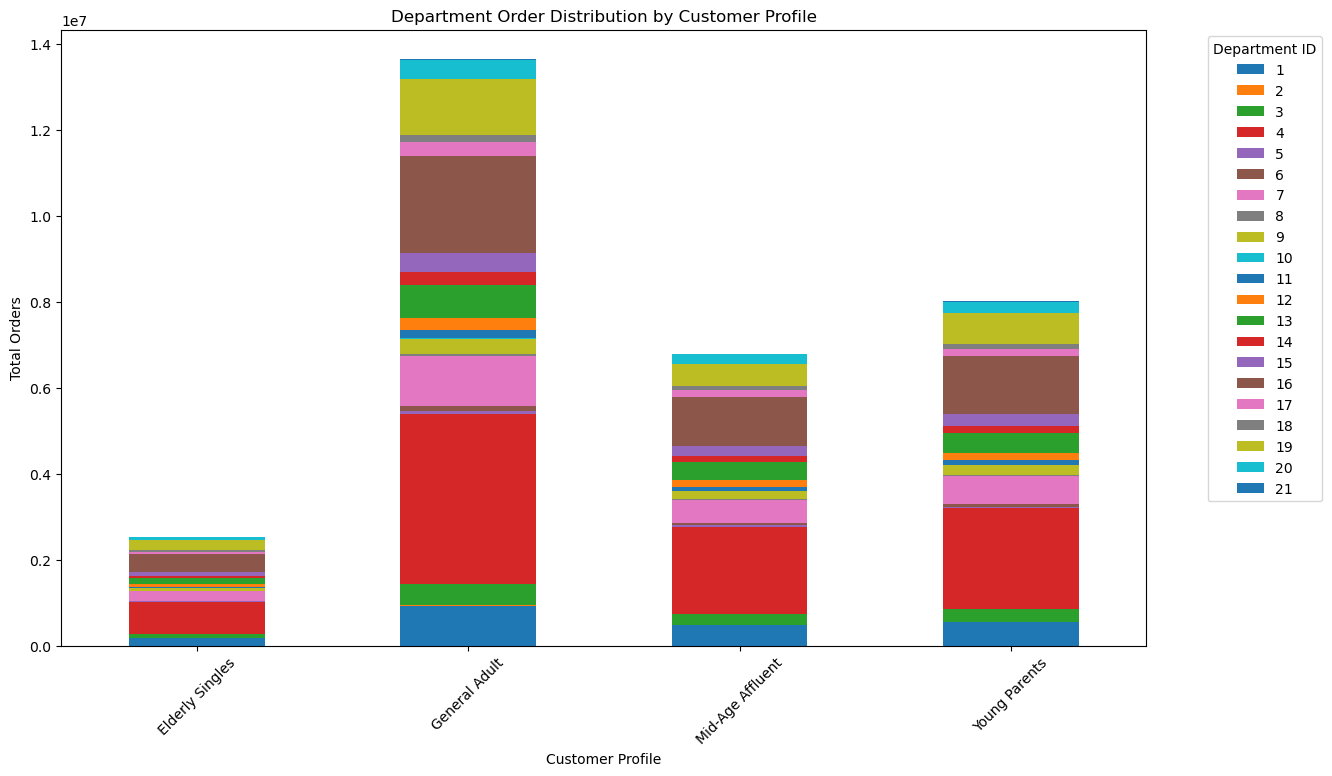

In [14]:
# 1. Prepare data for the plot
# Create a crosstab to count orders for each department within each profile
profile_department_counts = pd.crosstab(df_active['Customer_Profile'], df_active['department_id'])

# 2. Create the chart (Stacked Bar Chart)
# Plotting the counts for all departments can make the chart very wide.
profile_department_bar = profile_department_counts.plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 8),
    rot=45,
    title='Department Order Distribution by Customer Profile'
)

# Set labels for clarity
profile_department_bar.set_ylabel('Total Orders')
profile_department_bar.set_xlabel('Customer Profile')
profile_department_bar.legend(title='Department ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Export the chart to your Visualizations folder
profile_department_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profile_vs_department_bar.png'), bbox_inches='tight')

Finally, you create charts  to visually show your key findings from Step 7 (Profile vs. Region and Profile vs. Department). This is the most effective way to communicate complex data to stakeholders who may not be technical. Then, you export your final, clean DataFrame so you can move on to the reporting phase without losing your work.

In [15]:
# Export the final active customer data set as a pickle file
print("Exporting final active data set...")
df_active.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'instacart_final_active_data.pkl'))
print("Export complete!")

Exporting final active data set...
Export complete!
